Программа позволяет моделировать приемную систему 

Автор: Сергей Горчаков

Исходные данные

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

Wavelength = 1.
SizeOfAperture = 5.
NumberOfElements = 100
Distance = 1e-1
len_omega = 2**6
NumberOfFunctions = 2**2
min_omega = np.deg2rad(-50)
max_omega = np.deg2rad(50)

width = np.array(np.deg2rad([5.,5.]))
deltarange = np.deg2rad([-6,6])

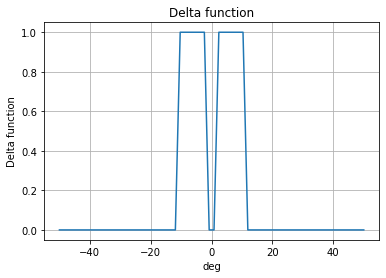

In [25]:
omega = np.linspace(min_omega,max_omega,len_omega)
teta = omega/2
min_teta = teta.min()
max_teta = teta.max()
len_teta = teta.shape[0]

def ddf(x,sig,delta):
    val = np.zeros_like(x)
    val[(-sig<=x+delta) & (x+delta<=sig)] = 1
    return val

def getSignal(range,width,deltarange):
    signal = 0.
    for i in np.arange(0,np.shape(width)[0]):
        signal += ddf(range,width[i],deltarange[i])
    return signal

signal = getSignal(omega,width,deltarange)
plt.cla()
plt.grid()
plt.title('Delta function')
plt.xlabel('deg')
plt.ylabel("Delta function")
plt.plot(np.rad2deg(omega),signal)


Угловое разрешение на основе критерия Рэлея

In [26]:
def getRayleighCriterion(Wavelength,SizeOfAperture):
    return Wavelength/SizeOfAperture 

print("Разрешение по Рэлею =",np.rad2deg(getRayleighCriterion(Wavelength,SizeOfAperture)),"deg")

Разрешение по Рэлею = 11.459155902616466 deg


Определяем диаграмму направленности сканирования антенны

C:\Users\Sergey\AppData\Local\Temp\ipykernel_8656\2317966925.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  f[j] = getDirectionalPattern(alpha)


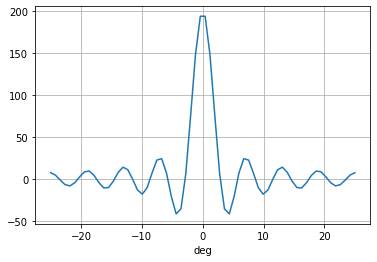

In [27]:
def getDirectionalPattern(alpha):
    d = Distance
    N = NumberOfElements
    f = 0.
    f0 = 1.
    k = 2*np.pi/Wavelength
    for m in np.arange(-N,N):
        f += f0*np.exp(-1j*k*d*m*(np.sin(alpha)))
    return f

f = np.zeros(len_teta)
j = -1
for alpha in teta:
    j += 1
    f[j] = getDirectionalPattern(alpha)
plt.plot(np.rad2deg(teta),f)
plt.grid()
plt.xlabel('deg')
plt.show()

Определяем принятый сигнал



In [28]:
def functionReceivedSignal(fi,alpha):
    return getDirectionalPattern(alpha - fi)*getSignal(fi,width,deltarange)

Интегрируем уравнение Фредгольма


In [29]:
U = np.zeros(len_teta)
j = -1
for alpha in teta:
    j += 1
    U[j],err = integrate.quad(functionReceivedSignal,min_teta,max_teta,args=(alpha,)) 

c:\Users\Sergey\AppData\Local\Programs\PythonCodingPack\lib\site-packages\scipy\integrate\quadpack.py:463: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
C:\Users\Sergey\AppData\Local\Temp\ipykernel_8656\2866149589.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  U[j],err = integrate.quad(functionReceivedSignal,min_teta,max_teta,args=(alpha,))


KeyboardInterrupt: 

График аппаратной функции

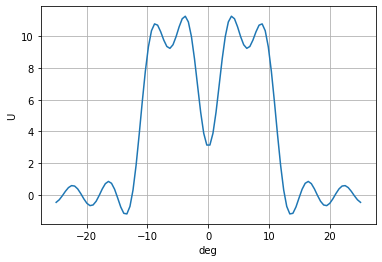

In [ ]:
plt.plot(np.rad2deg(teta),U)
plt.grid()
plt.xlabel('deg')
plt.ylabel('U')
plt.show()

Строим матрицу Адамара и Уолша

In [ ]:
def Hadamard2Walsh(n):
    # Function computes both Hadamard and Walsh Matrices of n=2^M order
    # (c) 2015 QuantAtRisk.com, coded by Pawel Lachowicz, adopted after
    # au.mathworks.com/help/signal/examples/discrete-walsh-hadamard-transform.html
    import numpy as np
    from scipy.linalg import hadamard
    from math import log
 
    hadamardMatrix=hadamard(n)
    HadIdx = np.arange(n)
    M = int(log(n,2)+1)
 
    for i in HadIdx:
        s=format(i, '#032b')
        s=s[::-1]; s=s[:-2]; s=list(s)
        x=[int(x) for x in s]
        x=np.array(x)
        if(i==0):
            binHadIdx=x
        else:
            binHadIdx=np.vstack((binHadIdx,x))
 
    binSeqIdx = np.zeros((n,M)).T
 
    for k in reversed(range(1,int(M))):
        tmp=np.bitwise_xor(binHadIdx.T[k],binHadIdx.T[k-1])
        binSeqIdx[k]=tmp
 
    tmp=np.power(2,np.arange(M)[::-1])
    tmp=tmp.T
    SeqIdx = np.dot(binSeqIdx.T,tmp)
 
    j=1
    for i in SeqIdx:
        if(j==1):
            walshMatrix=hadamardMatrix[int(i)]
        else:
            walshMatrix=np.vstack((walshMatrix,hadamardMatrix[int(i)]))
        j+=1
 
    return (hadamardMatrix,walshMatrix)

(A,W) = Hadamard2Walsh(len_teta)

def WHT(x):
    # Function computes (slow) Discrete Walsh-Hadamard Transform
    # for any 1D real-valued signal
    # (c) 2015 QuantAtRisk.com, by Pawel Lachowicz
    x=np.array(x)
    if(len(x.shape)<2): # make sure x is 1D array
        if(len(x)>3):   # accept x of min length of 4 elements (M=2)
            # check length of signal, adjust to 2**m
            n=len(x)
            M=trunc(log(n,2))
            x=x[0:2**M]
            h2=np.array([[1,1],[1,-1]])
            for i in range(M-1):
                if(i==0):
                    H=np.kron(h2,h2)
                else:
                    H=np.kron(H,h2)
 
            return (np.dot(H,x)/2.**M, x, M)
        else:
            print("HWT(x): Array too short!")
            raise SystemExit
    else:
        print("HWT(x): 1D array expected!")
        raise SystemExit

g = W

ValueError: n must be an positive integer, and n must be a power of 2

Вычисляем функцию Хи

In [ ]:
def functionHi(fi,alpha):
    return getDirectionalPattern(alpha - fi)

integ = np.zeros(NumberOfFunctions)
rng = np.linspace(min_teta,max_teta,NumberOfFunctions)

g = g[:,0:NumberOfFunctions]

j = -1
for alpha in rng:
    j += 1
    integ[j],err = integrate.quad(functionHi,min_teta,max_teta,args=(alpha,))

H = integ*g

c:\Users\Sergey\AppData\Local\Programs\PythonCodingPack\lib\site-packages\scipy\integrate\quadpack.py:463: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


Строим и решаем СЛАУ (B = H^-1*U)

In [ ]:
b = np.linalg.solve(H,U)
plt.plot(np.rad2deg(teta),b)
plt.grid()
plt.xlabel('deg')
plt.ylabel('Коэф-ты B')
plt.show()

ValueError: solve1: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (m,m),(m)->(m) (size 100 is different from 4)

Вычисление числа обусловленности

In [ ]:
invH = np.linalg.inv(H)
v = np.linalg.norm(invH)*np.linalg.norm(U)/np.linalg.norm(invH@U)
print("Число обусленности =",v)

Число обусленности = 8.083744780170177


Вычисляем распределение интенсивности - сверхразрешение (I = b*H)

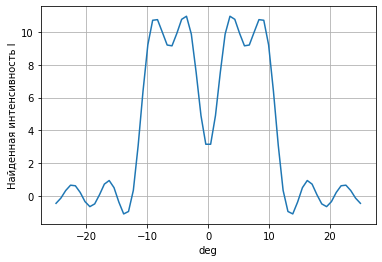

In [ ]:
I = b@H
plt.plot(np.rad2deg(teta),I)
plt.grid()
plt.xlabel('deg')
plt.ylabel('Найденная интенсивность I')
plt.show()